# Hyperparameter Tuning {#sec-hyperparameter-tuning}

Hyperparameter tuning is an important, but often difficult and computationally intensive task.
Changing the architecture of a neural network or the learning rate of an optimizer can have a significant impact on the performance.

The goal of hyperparameter tuning is to optimize the hyperparameters in a way that improves the performance of the machine learning or deep learning model.
The simplest, but also most computationally expensive, approach uses manual search (or trial-and-error [@Meignan:2015vp]).
Commonly encountered is simple random search, i.e., random and repeated selection of hyperparameters for evaluation, and lattice search ("grid search").
In addition, methods that perform directed search  and other model-free algorithms, i.e., algorithms that do not explicitly rely on a model, e.g., evolution strategies [@Bart13j] or pattern search [@Torczon00] play an important role.
Also, "hyperband", i.e., a multi-armed bandit strategy that dynamically allocates resources to a set of random configurations and uses successive bisections to stop configurations with poor performance [@Li16a], is very common in hyperparameter tuning.
The most sophisticated and efficient approaches are the Bayesian optimization and surrogate model based optimization methods, which are based on the optimization of cost functions determined by simulations or experiments.

We consider below a surrogate model based optimization-based hyperparameter tuning approach based on the Python version of the SPOT ("Sequential Parameter Optimization Toolbox") [@BLP05], which is suitable for situations where only limited resources are available. This may be due to limited availability and cost of hardware, or due to the fact that confidential data may only be processed locally, e.g., due to legal requirements.
Furthermore, in our approach, the understanding of algorithms is seen as a key tool for enabling transparency and explainability. This can be enabled, for example, by quantifying the contribution of machine learning and deep learning components (nodes, layers, split decisions, activation functions, etc.).
Understanding the importance of hyperparameters and the interactions between multiple hyperparameters plays a major role in the interpretability and explainability of machine learning models.
SPOT provides statistical tools for understanding hyperparameters and their interactions. Last but not least, it should be noted that the SPOT software code is available in the open source `spotPython` package on github^[[https://github.com/sequential-parameter-optimization](https://github.com/sequential-parameter-optimization)], allowing replicability of the results.
This tutorial descries the Python variant of SPOT, which is called `spotPython`. The R implementation is described in @bart21i.
SPOT is an established open source software that has been maintained for more than 15 years [@BLP05] [@bart21i].

This tutorial is structured as follows. The concept of the hyperparameter tuning software `spotPython` is described in @sec-spot. 
@sec-quickstart ("Quickstart") describes the execution of the example from the tutorial "Hyperparameter Tuning with Ray Tune" [@pyto23a].
@sec-hyperparameter-tuning-for-pytorch describes the integration of `spotPython` into the ``PyTorch`` training workflow in detail and presents the results. Finally, @sec-summary presents a summary and an outlook.

::: {.callout-note}
The corresponding ` .ipynb` notebook [@bart23e] is updated regularly and reflects updates and changes in the `spotPython` package.
It can be downloaded from [https://github.com/sequential-parameter-optimization/spotPython/blob/main/notebooks/14_spot_ray_hpt_torch_cifar10.ipynb](https://github.com/sequential-parameter-optimization/spotPython/blob/main/notebooks/14_spot_ray_hpt_torch_cifar10.ipynb).
:::


# The Hyperparameter Tuning Software SPOT {#sec-spot}

Surrogate model based optimization methods are common approaches in simulation and optimization. SPOT was developed because there is a great need for sound statistical analysis of simulation and optimization algorithms. SPOT includes methods for tuning based on classical regression and analysis of variance techniques.
It presents tree-based models such as classification and regression trees and random forests as well as Bayesian optimization (Gaussian process models, also known as Kriging). Combinations of different meta-modeling approaches are possible. SPOT comes with a sophisticated surrogate model based optimization method, that can handle discrete and continuous inputs. Furthermore, any model implemented in `scikit-learn` can be used out-of-the-box as a surrogate in `spotPython`.

SPOT implements key techniques such as exploratory fitness landscape analysis and sensitivity analysis. It can be used to understand the performance of various algorithms, while simultaneously giving insights into their algorithmic behavior.
In addition, SPOT can be used as an optimizer and for automatic and interactive tuning. Details on SPOT and its use in practice are given by @bart21i.

A typical hyperparameter tuning process with `spotPython` consists of the following steps:

1. Loading the data (training and test datasets), see @sec-data-loading.
2. Specification of the preprocessing model, see @sec-specification-of-preprocessing-model. This model is called `prep_model` ("preparation" or pre-processing).
The information required for the hyperparameter tuning is stored in the dictionary `fun_control`. Thus, the information needed for the execution of the hyperparameter tuning is available in a readable form.
3. Selection of the machine learning or deep learning model to be tuned, see @sec-selection-of-the-algorithm. This is called the `core_model`. Once the `core_model` is defined, then the associated hyperparameters are stored in the `fun_control` dictionary. First, the hyperparameters of the `core_model` are initialized with the default values of the `core_model`.
As default values we use the default values contained in the `spotPython` package for the algorithms of the `torch` package.
4. Modification of the default values for the hyperparameters used in `core_model`, see @sec-modification-of-default-values. This step is optional.
   1. numeric parameters are modified by changing the bounds.
   2. categorical parameters are modified by changing the categories ("levels").
5. Selection of target function (loss function) for the optimizer, see @sec-selection-of-target-function.
6. Calling SPOT with the corresponding parameters, see @sec-call-the-hyperparameter-tuner. The results are stored in a dictionary and are available for further analysis.
7. Presentation, visualization and interpretation of the results, see @sec-results-tuning.


# Quickstart {#sec-quickstart}

In [1]:
#| echo: true
#| eval: false
import numpy as np
import pandas as pd
import itertools
from math import inf
import torch
import torchmetrics
from torch.nn import CrossEntropyLoss, NLLLoss
import torch.nn as nn

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from spotPython.spot import spot
from spotPython.utils.init import fun_control_init
from spotPython.data.torchdata import load_data_cifar10
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    get_var_type,
    get_var_name,
    get_bound_values,
    get_one_core_model_from_X,
    get_default_hyperparameters_as_array
    )
from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch
from spotPython.torch.netvbdp import Net_vbdp
# from spotPython.torch.netcifar10 import Net_CIFAR10
from spotPython.torch.traintest import (
    train_tuned,
    test_tuned,
    )
from spotPython.torch.dataframedataset import DataFrameDataset
from spotPython.torch.mapk import MAPK
from spotPython.data.vbdp import modify_vbdp_dataframe

# Feature Engineering

In [2]:
#| echo: true
#| eval: false
fun_control = fun_control_init(task="classification", tensorboard_path="runs/23_spot_torch_vbdp")
fun_control.update({"show_batch_interval": 10_000})
# load data
train_df = pd.read_csv('./data/VBDP/train.csv')
# remove the id column
train_df = train_df.drop(columns=['id'])
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
target_column = "prognosis"
# # Encoder our prognosis labels as integers for easier decoding later
enc = OrdinalEncoder()
train_df[target_column] = enc.fit_transform(train_df[[target_column]])

* Luka's Approach

In [3]:
df_new = train_df.copy()
train_df = modify_vbdp_dataframe(df_new)
train_df.head()

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/spotPython/data/vbdp.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_vbdp[column_name] = 0
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/spotPython/data/vbdp.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_vbdp[column_name] = 0
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/spotPython/data/vbdp.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,9.0_urination_loss_5,9.0_abdominal_pain_5,9.0_yellow_eyes_5,9.0_yellow_skin_5,10.0_light_sensitivity_5,10.0_loss_of_appetite_5,10.0_slow_heart_rate_5,10.0_abdominal_pain_5,10.0_urination_loss_5,prognosis
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,7.0
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,3.0
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0,0,0,0,1,1,0,0,0,10.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,6.0


* feature engineering: 6112 features

In [4]:
# BIG_INPUT = False
# if BIG_INPUT:
#     # convert all train.df columns to int   
#     train_0 = train_df.astype(int)
#     col_prognosis = train_0['prognosis']
#     train_x = train_0.drop(columns=['prognosis'])
#     train_x = combine_features(train_x)
#     train_x['prognosis'] = col_prognosis
#     train_df = train_x.copy()
#     train_df.head()

* feature engineering: 69 features

In [5]:
# if BIG_INPUT == True:
#     # convert all train.df columns to int   
#     train_df = train_df.astype(int)
#     col_prognosis = train_df['prognosis']
#     train_features = cluster_features(train_df.drop(columns=['prognosis']))    
#     train_df = affinity_propagation_features(train_features)
#     train_df['prognosis'] = col_prognosis
# train_df.head()

In [6]:
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
train_df.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target_column, axis=1), train_df[target_column],
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=train_df[target_column])
trainset = pd.DataFrame(np.hstack((X_train, np.array(y_train).reshape(-1, 1))))
testset = pd.DataFrame(np.hstack((X_test, np.array(y_test).reshape(-1, 1))))
trainset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
testset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
print(train_df.shape)
print(trainset.shape)
print(testset.shape)


(707, 197)
(530, 197)
(177, 197)


In [7]:
dtype_x = torch.float32
dtype_y = torch.long
train_df = DataFrameDataset(train_df, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
train = DataFrameDataset(trainset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
test = DataFrameDataset(testset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
n_samples = len(train)

# Test Data Loading

In [8]:
from spotPython.torch.traintest import create_train_val_data_loaders
trainloader, testloader = create_train_val_data_loaders(train, 2, True, 0)
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print(inputs.shape)
    print(labels.shape)
    print(inputs)
    print(labels)
    break

torch.Size([2, 196])
torch.Size([2])
tensor([[1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
         1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.

## Test Network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 11)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

net = Net()
input_tensor = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
         0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
output = net(input_tensor)
print(output)

tensor([[0.0808, 0.0754, 0.0800, 0.0976, 0.0875, 0.0801, 0.0827, 0.0932, 0.1214,
         0.1035, 0.0977],
        [0.0748, 0.0763, 0.0651, 0.0897, 0.0900, 0.1024, 0.0903, 0.0834, 0.0992,
         0.1121, 0.1166]], grad_fn=<SoftmaxBackward0>)


In [10]:
# add the dataset to the fun_control
fun_control.update({"data": train_df, # full dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": target_column})


# Test Metric

In [11]:
y_pred = torch.tensor([[0.5, 0.2, 0.2],  # 0 is in top 2
                     [0.3, 0.4, 0.2],  # 1 is in top 2
                     [0.2, 0.4, 0.3],  # 2 is in top 2
                     [0.7, 0.2, 0.1]]) # 2 isn't in top 2

y_true = torch.tensor([0, 1, 2, 2])

mapk_metric = MAPK(k=2)
mapk_metric.update(y_pred, y_true)
result = mapk_metric.compute()
print(result) # tensor(0.37500)

0.375


In [12]:

# add the nn model to the fun_control dictionary
fun_control = add_core_model_to_fun_control(core_model=Net_vbdp,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict)
# modify the hyperparameter levels
fun_control = modify_hyper_parameter_bounds(fun_control, "_L0", bounds=[196, 196])
fun_control = modify_hyper_parameter_bounds(fun_control, "lr_mult", bounds=[1e-3, 1e-3])
fun_control = modify_hyper_parameter_bounds(fun_control, "sgd_momentum", bounds=[0.9, 0.9])
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer",["Adadelta", "Adagrad", "Adam", "AdamW", "Adamax", "ASGD", "NAdam"])
# select metric and loss function
# metric_torch = torchmetrics.Accuracy(task="multiclass", num_classes=11)
metric_torch = MAPK(k=3)
loss_torch = CrossEntropyLoss()
# loss_torch = NLLLoss()
fun_control.update({
               "metric_torch": metric_torch,
               "loss_function": loss_torch,
               "device": "cpu",
               })
# extract the variable types, names, and bounds
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})
lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

# get the default hyperparameters as array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)

# get the objective function
fun = HyperTorch().fun_torch

# initialize spot
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = 300,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": 20,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
# run spot
spot_tuner.run(X_start=X_start)



config: {'_L0': 196, 'l1': 8192, 'dropout_prob': 0.4475780541539, 'lr_mult': 0.001, 'batch_size': 16, 'epochs': 64, 'k_folds': 1, 'patience': 8, 'optimizer': 'Adagrad', 'sgd_momentum': 0.9}
Epoch: 1
Loss on hold-out set: 2.397284439631871
Accuracy on hold-out set: 0.10377358490566038
MAPK value on hold-out data: 0.1281446540880503
Epoch: 2
Loss on hold-out set: 2.3969532421657016
Accuracy on hold-out set: 0.16981132075471697
MAPK value on hold-out data: 0.190251572327044
Epoch: 3
Loss on hold-out set: 2.396784339632307
Accuracy on hold-out set: 0.2358490566037736
MAPK value on hold-out data: 0.26808176100628933
Epoch: 4
Loss on hold-out set: 2.3965597323008945
Accuracy on hold-out set: 0.2830188679245283
MAPK value on hold-out data: 0.3168238993710692
Epoch: 5
Loss on hold-out set: 2.396331821169172
Accuracy on hold-out set: 0.3490566037735849
MAPK value on hold-out data: 0.3443396226415094
Epoch: 6
Loss on hold-out set: 2.3962336097444807
Accuracy on hold-out set: 0.3443396226415094


In [13]:
# close tensorbaoard writer
if fun_control["writer"] is not None:
    fun_control["writer"].close()

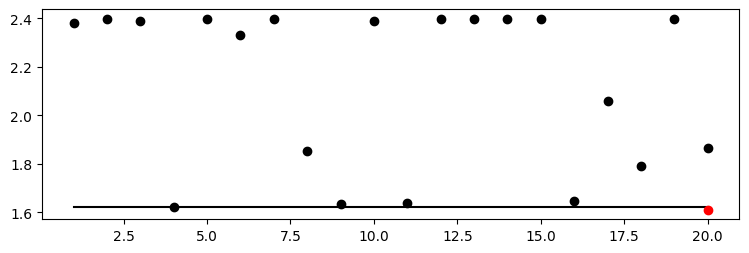

In [14]:
#| echo: true
#| eval: false
spot_tuner.plot_progress()

In [15]:
#| echo: true
#| eval: false
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name         | type   | default   |   lower |   upper |               tuned | transform             |   importance | stars   |
|--------------|--------|-----------|---------|---------|---------------------|-----------------------|--------------|---------|
| _L0          | int    | 64        |   196.0 |   196.0 |               196.0 | None                  |         0.00 |         |
| l1           | int    | 8         |     8.0 |    16.0 |                15.0 | transform_power_2_int |         0.55 | .       |
| dropout_prob | float  | 0.01      |     0.0 |     0.9 | 0.16443051466054226 | None                  |         0.00 |         |
| lr_mult      | float  | 1.0       |   0.001 |   0.001 |               0.001 | None                  |         0.00 |         |
| batch_size   | int    | 4         |     1.0 |     4.0 |                 2.0 | transform_power_2_int |         0.01 |         |
| epochs       | int    | 4         |     4.0 |     9.0 |                 9.0 | transform_power_2

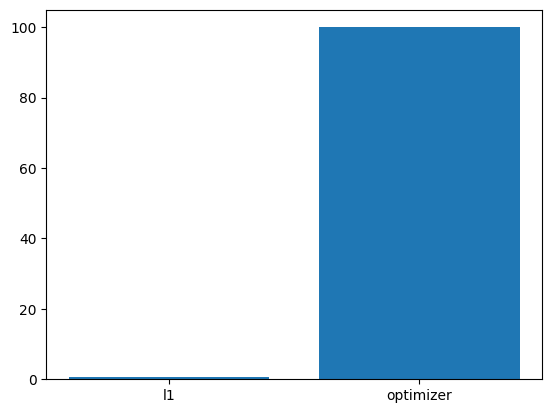

In [16]:
#| echo: true
#| eval: false
spot_tuner.plot_importance()

In [17]:
#| echo: true
#| eval: false
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_vbdp(
  (fc1): Linear(in_features=196, out_features=32768, bias=True)
  (fc2): Linear(in_features=32768, out_features=16384, bias=True)
  (fc3): Linear(in_features=16384, out_features=8192, bias=True)
  (fc4): Linear(in_features=8192, out_features=4096, bias=True)
  (fc5): Linear(in_features=4096, out_features=11, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout1): Dropout(p=0.16443051466054226, inplace=False)
  (dropout2): Dropout(p=0.08221525733027113, inplace=False)
)

In [25]:
from spotPython.torch.mapk import MAPK
metric_torch = MAPK(k=3)
fun_control.update({
               "metric_torch": metric_torch,               
               })

train_tuned(net=model_spot, train_dataset=train,
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        shuffle=True,
        device = "cpu",
        path=None,
        task=fun_control["task"],)

Epoch: 1
Loss on hold-out set: 2.393443570946747
Accuracy on hold-out set: 0.5235849056603774
MAPK value on hold-out data: 0.5440251572327044
Epoch: 2
Loss on hold-out set: 2.384627990002902
Accuracy on hold-out set: 0.6462264150943396
MAPK value on hold-out data: 0.630503144654088
Epoch: 3
Loss on hold-out set: 2.36006434908453
Accuracy on hold-out set: 0.6320754716981132
MAPK value on hold-out data: 0.6281446540880503
Epoch: 4
Loss on hold-out set: 2.2863289860059632
Accuracy on hold-out set: 0.6320754716981132
MAPK value on hold-out data: 0.5998427672955975
Epoch: 5
Loss on hold-out set: 2.1688780694637657
Accuracy on hold-out set: 0.6179245283018868
MAPK value on hold-out data: 0.6029874213836478
Epoch: 6
Loss on hold-out set: 2.068502178731954
Accuracy on hold-out set: 0.6698113207547169
MAPK value on hold-out data: 0.6485849056603774
Epoch: 7
Loss on hold-out set: 1.9770891688904673
Accuracy on hold-out set: 0.7358490566037735
MAPK value on hold-out data: 0.7154088050314465
Epoch

In [19]:
test_tuned(net=model_spot, test_dataset=test,
            shuffle=False,
            loss_function=fun_control["loss_function"],
            metric=fun_control["metric_torch"],
            device = "cpu",
            task=fun_control["task"],)

Error in Net_Core. Call to test_tuned() failed. err=ValueError('Unknown task: None'), type(err)=<class 'ValueError'>
Final evaluation: Validation loss: nan
Final evaluation: Validation metric: nan
----------------------------------------------


(nan, nan, nan)

## Cross-validated Evaluations

* This is the evaluation that will be used in the comparison (evaluatecv has to be updated before, to get metric vlaues!):

In [ ]:
from spotPython.torch.traintest import evaluate_cv
# modify k-kolds:
setattr(model_spot, "kfolds",  10)
evaluate_cv(net=model_spot, dataset=fun_control["data"], task=fun_control["task"], writer=fun_control["writer"])

l1:  0.545526153408727
optimizer:  100.0


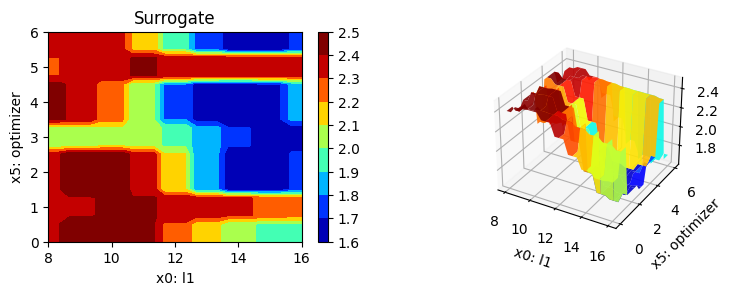

In [20]:
#| echo: true
#| eval: false
spot_tuner.plot_important_hyperparameter_contour()

# Hyperparameter Tuning for PyTorch With `spotPython` {#sec-hyperparameter-tuning-for-pytorch}

In this tutorial, we will show how `spotPython` can be integrated into the `PyTorch`
training workflow. It is based on the tutorial "Hyperparameter Tuning with Ray Tune" from the `PyTorch` documentation [@pyto23a], which is an extension of the tutorial "Training a Classifier" [@pyto23b] for training a CIFAR10 image classifier.

This document refers to the following software versions:

- ``python``: 3.10.10
- ``torch``: 2.0.1
- ``torchvision``: 0.15.0
- ``spotPython``: 0.2.6

`spotPython` can be installed via pip^[Alternatively, the source code can be downloaded from gitHub: [https://github.com/sequential-parameter-optimization/spotPython](https://github.com/sequential-parameter-optimization/spotPython).].

```{raw}
!pip install spotPython
```

Results that refer to the `Ray Tune` package are taken from [https://PyTorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html](https://PyTorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)^[We were not able to install `Ray Tune` on our system. Therefore, we used the results from the `PyTorch` tutorial.].

## Setup {#sec-setup}

Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size and the device that is used.

In [21]:
MAX_TIME = 60
INIT_SIZE = 20
DEVICE = "cpu" # "cuda:0"

In [22]:
#| echo: false
import os
import copy
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '14-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
print(experiment_name)
if not os.path.exists('./figures'):
    os.makedirs('./figures')

14-torch_bartz09_60min_20init_2023-06-03_08-19-30


In [23]:
#| echo: false
from tabulate import tabulate
import warnings
import json
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import torch
import torchmetrics
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    get_bound_values,
    get_default_values,
    get_default_hyperparameters_as_array,
    get_var_name,
    get_var_type,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
)
from spotPython.torch.traintest import (
    evaluate_cv,
    evaluate_hold_out,
    train_tuned,
    test_tuned,
    )
from spotPython.utils.eda import gen_design_table
from spotPython.utils.transform import transform_hyper_parameter_values
from spotPython.utils.init import fun_control_init

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.data.torchdata import load_data_cifar10
from spotPython.fun.hypertorch import HyperTorch
from spotPython.torch.netcifar10 import Net_CIFAR10

warnings.filterwarnings("ignore")

## Initialization of the `fun_control` Dictionary

`spotPython` uses a Python dictionary for storing the information required for the hyperparameter tuning process. This dictionary is called `fun_control` and is initialized with the function `fun_control_init`. The function `fun_control_init` returns a skeleton  dictionary. The dictionary is filled with the required information for the hyperparameter tuning process. It stores the hyperparameter tuning settings, e.g., the deep learning network architecture that should be tuned, the classification (or regression) problem, and the data that is used for the tuning.
The dictionary is used as an input for the SPOT function.


In [24]:
#| echo: true
fun_control = fun_control_init()

TypeError: fun_control_init() missing 1 required positional argument: 'task'

## PyTorch Data Loading

In [ ]:
from torch.utils.data import DataLoader
from spotPython.torch.dataframedataset import CSVDataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import numpy as np

import pandas as pd
import torch

train_df = pd.read_csv('./data/VBDP/train.csv')
# remove the id column
train_df = train_df.drop(columns=['id'])
target_column = "prognosis"
# Encoder our prognosis labels as integers for easier decoding later
enc = OrdinalEncoder()
train_df[target_column] = enc.fit_transform(train_df[[target_column]])
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target_column, axis=1), train_df[target_column],
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=train_df[target_column])
trainset = pd.DataFrame(np.hstack((X_train, np.array(y_train).reshape(-1, 1))))
testset = pd.DataFrame(np.hstack((X_test, np.array(y_test).reshape(-1, 1))))


train = CSVDataset(trainset)
test = CSVDataset(testset)
# my_dataloader = DataLoader(my_dataset)

## Data Loading {#sec-data-loading}

The data loading process is implemented in the same manner as described in the Section "Data loaders" in @pyto23a.
The data loaders are wrapped into the function `load_data_cifar10` which is identical to the function `load_data` in @pyto23a. A global data directory is used, which allows sharing the data directory between different trials.

In [ ]:
#| echo: true
def load_data_cifar10(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

The method `load_data_cifar10` is part of the `spotPython` package and can be imported from `spotPython.data.torchdata`.

In the following step, the test and train data are added to the dictionary `fun_control`.

In [ ]:
#| echo: true
# train, test = load_data_cifar10()
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({
    "train": train,
    "test": test,
    "n_samples": n_samples})

## Specification of the Preprocessing Model {#sec-specification-of-preprocessing-model}

After the training and test data are specified and added to the `fun_control` dictionary, `spotPython` allows the specification of a data preprocessing pipeline, e.g., for the scaling of the data or for the one-hot encoding of categorical variables. The preprocessing model is called `prep_model` ("preparation" or pre-processing) and includes steps that are not subject to the hyperparameter tuning process. The preprocessing model is specified in the `fun_control` dictionary. The preprocessing model can be implemented as a `sklearn` pipeline. The following code shows a typical preprocessing pipeline:

```{raw}
categorical_columns = ["cities", "colors"]
one_hot_encoder = OneHotEncoder(handle_unknown="ignore",
                                    sparse_output=False)
prep_model = ColumnTransformer(
        transformers=[
             ("categorical", one_hot_encoder, categorical_columns),
         ],
         remainder=StandardScaler(),
     )
```

Because the Ray Tune (`ray[tune]`) hyperparameter tuning as described in @pyto23a does not use a preprocessing model, the preprocessing model is set to `None` here.

In [ ]:
#| echo: true
prep_model = None
fun_control.update({"prep_model": prep_model})

## Select `algorithm` and `core_model_hyper_dict` {#sec-selection-of-the-algorithm}

The same neural network model as implemented in the section "Configurable neural network" of the `PyTorch` tutorial [@pyto23a] is used here.
We will show the implementation from @pyto23a in @sec-implementation-with-raytune first, before the extended implementation with `spotPython` is shown in @sec-implementation-with-spotpython.


### Implementing a Configurable Neural Network With Ray Tune{#sec-implementation-with-raytune}

We used the same hyperparameters that are implemented as configurable in the `PyTorch` tutorial. We specify the layer sizes, namely `l1` and `l2`, of the fully connected layers:

```{raw}
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

```

The learning rate, i.e., `lr`,  of the optimizer is made configurable, too:

```{raw}
optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
```

### Implementing a Configurable Neural Network With spotPython {#sec-implementation-with-spotpython}

`spotPython` implements a class which is similar to the class described in the `PyTorch` tutorial. The class is called `Net_CIFAR10` and is implemented in the file `netcifar10.py`.

```{raw}
from torch import nn
import torch.nn.functional as F
import spotPython.torch.netcore as netcore


class Net_CIFAR10(netcore.Net_Core):
    def __init__(self, l1, l2, lr_mult, batch_size, epochs, k_folds, patience, optimizer, sgd_momentum):
        super(Net_CIFAR10, self).__init__(
            lr_mult=lr_mult,
            batch_size=batch_size,
            epochs=epochs,
            k_folds=k_folds,
            patience=patience,
            optimizer=optimizer,
            sgd_momentum=sgd_momentum,
        )
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

`Net_CIFAR10` inherits from the class `Net_Core` which is implemented in the file `netcore.py`.  It implements the additional attributes that are common to all neural network models. The attributes are the learning rate multiplier `lr_mult`, the batch size `batch_size`, the number of epochs `epochs`, the number of folds `k_folds` for the cross validation, and the patience `patience` for the early stopping. The class `Net_Core` is shown below.

```{raw}
from torch import nn


class Net_Core(nn.Module):
    def __init__(self, lr_mult, batch_size, epochs, k_folds, patience, optimizer, sgd_momentum):
        super(Net_Core, self).__init__()
        self.lr_mult = lr_mult
        self.batch_size = batch_size
        self.epochs = epochs
        self.k_folds = k_folds
        self.patience = patience
        self.optimizer = optimizer
        self.sgd_momentum = sgd_momentum
```

:::{.callout-note}
#### The `Net_Core` class

The `Net_Core` class is implemented in the file `netcore.py`. It implements hyperparameters as attributes, that are not used by the `core_model`, e.g.:

* optimizer (`optimizer`),
* learning rate (`lr`),
* batch size (`batch_size`),
* epochs (`epochs`),
* k_folds (`k_folds`), and
* early stopping criterion "patience" (`patience`).

Users can add further attributes to the class.
:::

### Comparison of the Approach Described in the PyTorch Tutorial With spotPython {#sec-comparison}

Comparing the class `Net` from the `PyTorch` tutorial and the class `Net_CIFAR10` from `spotPython`, we see that the class `Net_CIFAR10` has additional attributes and does not inherit from `nn` directly. It adds an additional class, `Net_core`, that takes care of additional attributes that are common to all neural network models, e.g., the learning rate multiplier `lr_mult` or the batch size `batch_size`.

`spotPython`'s `core_model` implements an instance of the `Net_CIFAR10` class. In addition to the basic neural network model, the `core_model` can use these additional attributes.
`spotPython` provides methods for handling these additional attributes to guarantee 100% compatibility with the `PyTorch` classes. The method `add_core_model_to_fun_control` adds the hyperparameters and additional attributes to the `fun_control` dictionary. The method is shown below.

In [ ]:
#| echo: true
core_model = Net_CIFAR10
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

## The Search Space {#sec-search-space}

In @sec-configuring-the-search-space-with-ray-tune, we first describe how to configure the search space with `ray[tune]` (as shown in @pyto23a) 
and then how to configure the search space with `spotPython` in @sec-configuring-the-search-space-with-spotpython.

### Configuring the Search Space With Ray Tune {#sec-configuring-the-search-space-with-ray-tune}

 Ray Tune's search space can be configured as follows [@pyto23a]:

```{raw}
config = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16])
}
```
The ``tune.sample_from()`` function enables the user to define sample
methods to obtain hyperparameters. In this example, the ``l1`` and ``l2`` parameters
should be powers of 2 between 4 and 256, so either 4, 8, 16, 32, 64, 128, or 256.
The ``lr`` (learning rate) should be uniformly sampled between 0.0001 and 0.1. Lastly,
the batch size is a choice between 2, 4, 8, and 16.

At each trial, `ray[tune]` will randomly sample a combination of parameters from these
search spaces. It will then train a number of models in parallel and find the best
performing one among these. `ray[tune]` uses the ``ASHAScheduler`` which will terminate bad
performing trials early.

### Configuring the Search Space With spotPython {#sec-configuring-the-search-space-with-spotpython}

#### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses `JSON` files for the specification of the hyperparameters.
Users can specify their individual `JSON` files, or they can use the `JSON` files provided by `spotPython`.
The `JSON` file for the `core_model` is called `torch_hyper_dict.json`.

In contrast to `ray[tune]`, `spotPython` can handle numerical, boolean, and categorical hyperparameters. They can be specified in the `JSON` file in a similar way as the numerical hyperparameters as shown below.
Each entry in the `JSON` file represents one hyperparameter with the following structure:
`type`, `default`, `transform`, `lower`, and `upper`.


```json
"factor_hyperparameter": {
    "levels": ["A", "B", "C"],
    "type": "factor",
    "default": "B",
    "transform": "None",
    "core_model_parameter_type": "str",
    "lower": 0,
    "upper": 2},
```

The corresponding entries for the `Net_CIFAR10` class are shown below.

```json
{"Net_CIFAR10":
    {
        "l1": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "l2": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "lr_mult": {
            "type": "float",
            "default": 1.0,
            "transform": "None",
            "lower": 0.1,
            "upper": 10},
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "epochs": {
            "type": "int",
            "default": 3,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "k_folds": {
            "type": "int",
            "default": 2,
            "transform": "None",
            "lower": 2,
            "upper": 3},
        "patience": {
            "type": "int",
            "default": 5,
            "transform": "None",
            "lower": 2,
            "upper": 10},
        "optimizer": {
            "levels": ["Adadelta",
                       "Adagrad",
                       "Adam",
                       "AdamW",
                       "SparseAdam",
                       "Adamax",
                       "ASGD",
                       "LBFGS",
                       "NAdam",
                       "RAdam",
                       "RMSprop",
                       "Rprop",
                       "SGD"],
            "type": "factor",
            "default": "SGD",
            "transform": "None",
            "class_name": "torch.optim",
            "core_model_parameter_type": "str",
            "lower": 0,
            "upper": 12},
        "sgd_momentum": {
            "type": "float",
            "default": 0.0,
            "transform": "None",
            "lower": 0.0,
            "upper": 1.0}
    }
}
```


## Modifying the Hyperparameters {#sec-modification-of-hyperparameters}

Ray tune [@pyto23a] does not provide a way to change the specified hyperparameters without re-compilation. However, `spotPython` provides functions for modifying the hyperparameters, their bounds and factors as well as for activating and de-activating hyperparameters without re-compilation of the Python source code. These functions are described in the following.

### Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model` {#sec-modification-of-default-values}

After specifying the model, the corresponding hyperparameters, their types and bounds are loaded from the `JSON` file `torch_hyper_dict.json`. After loading, the user can modify the hyperparameters, e.g., the bounds.
`spotPython` provides a simple rule for de-activating hyperparameters: If the lower and the upper bound are set to identical values, the hyperparameter is de-activated. This is useful for the hyperparameter tuning, because it allows to specify a hyperparameter in the `JSON` file, but to de-activate it in the `fun_control` dictionary. This is done in the next step.


### Modify Hyperparameters of Type numeric and integer (boolean)

Since the hyperparameter `k_folds` is not used in the `PyTorch` tutorial, it is de-activated here by setting the lower and upper bound to the same value. Note, `k_folds` is of type "integer".

In [ ]:
#| echo: true
fun_control = modify_hyper_parameter_bounds(fun_control, "batch_size", bounds=[1, 5])
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[0, 0])
fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[3, 3])
fun_control["core_model_hyper_dict"]

### Modify Hyperparameter of Type factor

In a similar manner as for the numerical hyperparameters, the categorical hyperparameters can be modified.
New configurations can be chosen by adding or deleting levels. For example, the hyperparameter `optimizer` can be re-configured as follows:

In the following setting, two optimizers (`"SGD"` and `"Adam"`) will be compared during the `spotPython` hyperparameter tuning. The hyperparameter `optimizer` is active.

In [ ]:
#| echo: true
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer", ["SGD", "Adam"])

The hyperparameter `optimizer` can be de-activated by choosing only one value (level), here: `"SGD"`.

In [ ]:
#| echo: true
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer", ["SGD"])

As discussed in @sec-optimizers, there are some issues with the LBFGS optimizer. Therefore, the usage of the LBFGS optimizer is not  deactivated in `spotPython` by default. However, the LBFGS optimizer can be activated by adding it to the list of optimizers.
`Rprop`  was removed, because it does perform very poorly (as some pre-tests have shown). However, it can also be activated by adding it to the list of optimizers.
Since `SparseAdam` does not support dense gradients, `Adam` was used instead.
Therefore, there are 10 default optimizers:

In [ ]:
#| echo: true
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer",["Adadelta",
     "Adagrad", "Adam", "AdamW", "Adamax", "ASGD", "NAdam", "RAdam",
      "RMSprop", "SGD"])

### Optimizers {#sec-optimizers}

@tbl-optimizers shows some of the optimizers available in `PyTorch`:

| Optimizer | lr  | mom | weight | damp | nest | rho | lr_sc | lr_decay | betas | lambd | alpha | mom_decay | etas | step_s|
| :-----    |:--- |:--- | :---   | :--- | :--- |:--- | :---  | :---     | :---- |:----  |:----  | :----     | :--- | :--- |
| Adadelta  | -   | -   |  0.    | -    | -    | 0.9 | 1.0   | -        | -     | -     |-      |    -      |   -  | -    |
| Adagrad   |1e-2 | -   | 0.     | -    | -    | -   | -     | 0.       | -     | -     |-      | -         |   -  | -    |
| Adam      |1e-3 | -   | 0.     | -    | -    | -   | -     | -        |(0.9,0.999)| - |-      |   -       |   -  | -    |
| AdamW     |1e-3 | -   | 1e-2   | -    | -    | -   | -     | -        |(0.9,0.999)| - |  -    |       -   |   -  | -    |
| SparseAdam | 1e-3| -  | -      | -    | -    | -   | -     | -        |(0.9,0.999)|-  |-      | -         |   -  | -    |
| Adamax | 2e-3    | -  | 0.     | -    | -    | -   | -     | -        |(0.9, 0.999)|- |-      | -         |   -  | -    |
| ASGD   | 1e-2 |  0.9  | 0.     | -    | False| -   | -     | -        | -        |1e-4| 0.75  |  -        |  -   | -    |
| LBFGS |  1.   | -     | -      | -    | -    | -   | -     | -        | -        | -  |-      | -         |  -   |   -  |
| NAdam | 2e-3  | -     | 0.     | -    | -    | -   | -     | -        |(0.9,0.999)| - |-      | 0         |   -  | -    |
| RAdam | 1e-3  | -     | 0.     | -    | -    | -   | -     | -        |(0.9,0.999)| - |-      | -         |   -  | -    |
| RMSprop | 1e-2| 0. |   0.      |  -   | -    | -   | -     | -        |(0.9,0.999)| - |-      | -         |   -  | -    |
| Rprop |  1e-2 | -  | -         | -    | -    | -   | -     | -        | -         | -| (0.5,1.2)| (1e-6, 50)| -   | -   |
| SGD   | required | 0.| 0.      | 0.   | False | -  | -     | -        | -         |- |-       | -         |   -  | -    |

: Optimizers available in PyTorch (selection). "mom" denotes `momentum`, "weight" `weight_decay`, "damp" `dampening`, "nest" `nesterov`,  "lr_sc" `learning rate for scaling delta`, "mom_dec" for `momentum_decay`, and "step_s" for `step_sizes`.  The default values are shown in the table. {#tbl-optimizers}

`spotPython` implements an `optimization` handler that maps the optimizer names to the corresponding `PyTorch` optimizers.

::: {.callout-note}
### A note on LBFGS

We recommend deactivating `PyTorch`'s LBFGS optimizer, because it does not perform very well. The  `PyTorch` documentation, see [https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html#torch.optim.LBFGS](https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html#torch.optim.LBFGS), states:

> This is a very memory intensive optimizer (it requires additional `param_bytes * (history_size + 1)` bytes). If it doesn’t fit in memory try reducing the history size, or use a different algorithm.


Furthermore, the LBFGS optimizer is not compatible with the `PyTorch` tutorial. The reason is that the LBFGS optimizer requires the `closure` function, which is not implemented in the `PyTorch` tutorial. Therefore, the `LBFGS` optimizer is recommended here.
:::

Since there are 10 optimizers in the portfolio, it is not recommended tuning the hyperparameters that effect one single optimizer only.

::: {.callout-note}
#### A note on the learning rate
`spotPython` provides a multiplier for the default learning rates, `lr_mult`, because optimizers use different learning rates. Using a multiplier for the learning rates might enable a simultaneous tuning of the learning rates for all optimizers. However, this is not recommended, because the learning rates are not comparable across optimizers. Therefore, we recommend fixing the learning rate for all optimizers if multiple optimizers are used. This can be done by setting the lower and upper bounds of the learning rate multiplier to the same value as shown below.
:::

Thus, the learning rate, which affects the `SGD` optimizer, will be set to a fixed value. We choose the default value of `1e-3` for the learning rate, because it is used in other `PyTorch` examples (it is also the default value used by `spotPython` as defined in the `optimizer_handler()` method). We recommend tuning the learning rate later, when a reduced set of optimizers is fixed.
Here, we will demonstrate how to select in a screening phase the optimizers that should be used for the hyperparameter tuning.

For the same reason, we will fix the `sgd_momentum` to `0.9`. 

In [ ]:
#| echo: true
fun_control = modify_hyper_parameter_bounds(fun_control, "lr_mult", bounds=[1.0, 1.0])
fun_control = modify_hyper_parameter_bounds(fun_control, "sgd_momentum", bounds=[0.9, 0.9])

## Evaluation  {#sec-selection-of-target-function}

The evaluation procedure requires the specification of two elements:

1. the way how the data is split into a train and a test set and
2. the loss function (and a metric).

### Hold-out Data Split and Cross-Validation

As a default, `spotPython` provides a standard hold-out data split and cross validation.

#### Hold-out Data Split

If a hold-out data split is used, the data will be partitioned into a training, a validation, and a test data set.
The split depends on the setting of the `eval` parameter. If `eval` is set to `train_hold_out`, one data set, usually the original training data set, is split into a new training and a validation data set. The training data set is used for training the model. The validation data set is used for the evaluation of the hyperparameter configuration and early stopping to prevent overfitting. In this case, the original test data set is not used.
The following splits are performed in the hold-out setting:
$\{\text{train}_0, \text{test}\} \rightarrow \{\text{train}_1, \text{validation}_1, \text{test}\}$, where $\text{train}_1 \cup \text{validation}_1 = \text{train}_0$.


::: {.callout-note}
`spotPython` returns the hyperparameters of the machine learning and deep learning models, e.g., number of layers, learning rate, or optimizer, but not the model weights. Therefore, after the SPOT run is finished, the corresponding model with the optimized architecture has to be trained again with the best hyperparameter configuration. The training is performed on the training data set. The test data set is used for the final evaluation of the model.

Summarizing, the following splits are performed in the hold-out setting:

1. Run `spotPython` with `eval` set to `train_hold_out` to determine the best hyperparameter configuration.
2. Train the model with the best hyperparameter configuration ("architecture")  on the training data set:
   * `train_tuned(model_spot, train, "model_spot.pt")`.
3. Test the model on the test data:
   * `test_tuned(model_spot, test, "model_spot.pt")`

These steps will be exemplified in the following sections.
:::

In addition to this `hold-out` setting, `spotPython` provides another hold-out setting, where an explicit test data is specified by the user that will be used as the validation set. To choose this option, the `eval` parameter is set to `test_hold_out`. In this case, the training data set is used for the model training. Then, the explicitly defined test data set is used for the evaluation of the hyperparameter configuration (the validation).

#### Cross-Validation

The cross validation setting is used by setting the `eval` parameter to `train_cv` or `test_cv`. In both  cases, the data set is split into $k$ folds. The model is trained on $k-1$ folds and evaluated on the remaining fold. This is repeated $k$ times, so that each fold is used exactly once for evaluation. The final evaluation is performed on the test data set. The cross validation setting is useful for small data sets, because it allows to use all data for training and evaluation. However, it is computationally expensive, because the model has to be trained $k$ times.

::: {.callout-note}
Combinations of the above settings are possible, e.g., cross validation can be used for training and hold-out for evaluation or *vice versa*. Also, cross validation can be used for training and testing. Because cross validation is not used in the `PyTorch` tutorial [@pyto23a], it is not considered further here.
:::

#### Overview of the Evaluation Settings

##### Settings for the Hyperparameter Tuning

@tbl-eval-settings provides an overview of the training evaluations.

| `eval` | `train` | `test` | function | comment |
| --- | :---: | :---: |     --- | --- |
| `"train_hold_out"` | $\checkmark$ |  |  `train_hold_out()`, `validate_fold_or_hold_out()` for early stopping|  splits the `train` data set internally|
| `"test_hold_out"` | $\checkmark$ | $\checkmark$ | `train_hold_out()`, `validate_fold_or_hold_out()` for early stopping  |use the `test data set` for `validate_fold_or_hold_out()` |
| `"train_cv"` | $\checkmark$ |              |  `evaluate_cv(net, train)`  | CV using the  `train` data set |
| `"test_cv"` |               | $\checkmark$ |  `evaluate_cv(net, test)` | CV using the  `test` data set . Identical to `"train_cv"`, uses only test data.|
: Overview of the evaluation settings. {#tbl-eval-settings}

* `"train_cv"` and `"test_cv"` use `sklearn.model_selection.KFold()` internally.

@sec-data-splitting (in the Appendix) provides more details on the data splitting.

#### Settings for the Final Evaluation of the Tuned Architecture

##### Training of the Tuned Architecture
`train_tuned(model, train)`: train the model with the best hyperparameter configuration (or simply the default) on the training data set. It splits the `train`data into new `train` and `validation` sets using  `create_train_val_data_loaders()`, which calls `torch.utils.data.random_split()` internally. Currently, 60% of the data is used for training and 40% for validation. The `train` data is used for training the model with `train_hold_out()`. The `validation` data is used for early stopping using `validate_fold_or_hold_out()` on the `validation` data set.

##### Testing of the Tuned Architecture

`test_tuned(model, test)`: test the model on the test data set. No data splitting is performed. The (trained) model is evaluated using the `validate_fold_or_hold_out()` function.

Note: During training, `shuffle` is set to `True`, whereas during testing, `shuffle` is set to `False`.

@sec-final-model-evaluation describes the final evaluation of the tuned architecture.


### Loss Functions and Metrics

The key `"loss_function"` specifies the loss function which is used during the optimization. There are several different loss functions under `PyTorch`'s `nn` package. For example, a simple loss is `MSELoss`, which computes the mean-squared error between the output and the target. In this tutorial we will use `CrossEntropyLoss`, because it is also used in the `PyTorch` tutorial.

In [ ]:
#| echo: true
from torch.nn import CrossEntropyLoss
loss_function = CrossEntropyLoss()
fun_control.update({"loss_function": loss_function})

In addition to the loss functions, `spotPython` provides access to a large number of metrics. The key `"metric_sklearn"` is used for metrics that follow the `scikit-learn` conventions. The key `"river_metric"` is used for the river based evaluation [@mont20a] via `eval_oml_iter_progressive`, and the key `"metric_torch"` is used for the metrics from `TorchMetrics`. `TorchMetrics` is a collection of more than 90 PyTorch metrics^[[https://torchmetrics.readthedocs.io/en/latest/.](https://torchmetrics.readthedocs.io/en/latest/)].
Because the `PyTorch` tutorial uses the accuracy as metric, we use the same metric here. Currently, accuracy is computed in the tutorial's example code. We will use `TorchMetrics` instead, because it offers more flexibilty, e.g., it can be used for regression and classification. Furthermore, `TorchMetrics` offers the following advantages:

* A standardized interface to increase reproducibility
* Reduces Boilerplate
* Distributed-training compatible
* Rigorously tested
* Automatic accumulation over batches
* Automatic synchronization between multiple devices

Therefore, we set 

In [ ]:
#| echo: true
metric_torch = torchmetrics.Accuracy(task="multiclass", num_classes=10)

In [ ]:
#| echo: true
loss_function = CrossEntropyLoss()
weights = 1.0
metric_torch = torchmetrics.Accuracy(task="multiclass", num_classes=10)
shuffle = True
eval = "train_hold_out"
device = DEVICE
show_batch_interval = 100_000
path="torch_model.pt"

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric_torch": metric_torch,
               "metric_river": None,
               "metric_sklearn": None,
               "loss_function": loss_function,
               "shuffle": shuffle,
               "eval": eval,
               "device": device,
               "show_batch_interval": show_batch_interval,
               "path": path,
               })

## Calling the SPOT Function {#sec-call-the-hyperparameter-tuner}

In [ ]:
#| echo: false
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

Now, the dictionary `fun_control` contains all information needed for the hyperparameter tuning. Before the hyperparameter tuning is started, it is recommended to take a look at the experimental design. The method `gen_design_table` generates a design table as follows:

In [ ]:
#| echo: true
print(gen_design_table(fun_control))

This allows to check if all information is available and if the information is correct.  @tbl-design shows the experimental design for the hyperparameter tuning. Hyperparameter transformations are shown in the column "transform", e.g., the `l1` default is `5`, which results in the value $2^5 = 32$ for the network, because the transformation ` transform_power_2_int` was selected in the `JSON` file. The default value of the `batch_size` is set to `4`, which results in a batch size of $2^4 = 16$. 


| name       | type   | default          |   lower |   upper | transform             |
|------------|--------|------------------|---------|---------|-----------------------|
| l1         | int    | 5                |   2     |   9     | transform_power_2_int |
| l2         | int    | 5                |   2     |   9     | transform_power_2_int |
| lr         | float  | 0.001            |   0.001 |   0.001 | None                  |
| batch_size | int    | 4                |   1     |   5     | transform_power_2_int |
| epochs     | int    | 3                |   3     |   4     | transform_power_2_int |
| k_folds    | int    | 2                |   0     |   0     | None                  |
| patience   | int    | 5                |   3     |   3     | None                  |
| optimizer  | factor | SGD              |   0     |   9     | None                  |

: Experimental design for the hyperparameter tuning. The table shows the hyperparameters, their types, default values, lower and upper bounds, and the transformation function. The transformation function is used to transform the hyperparameter values from the unit hypercube to the original domain. The transformation function is applied to the hyperparameter values before the evaluation of the objective function. {#tbl-design}

The objective function `fun_torch` is selected next. It implements an interface from `PyTorch`'s training, validation, and  testing methods to `spotPython`.

In [ ]:
#| echo: true
fun = HyperTorch().fun_torch

In [ ]:
#| echo: false
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)

The `spotPython` hyperparameter tuning is started by calling the `Spot` function. Here, we will run the tuner for approximately 30 minutes (`max_time`). Note: the initial design is always evaluated in the `spotPython` run. As a consequence, the run may take longer than specified by `max_time`, because the evaluation time of initial design (here: `init_size`, 10 points) is performed independently of `max_time`.

In [ ]:
#| echo: true
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

During the run, the following output is shown:

```{raw}
config: {'l1': 4, 'l2': 64, 'lr_mult': 1.0, 'batch_size': 16, 'epochs': 16, 'k_folds': 0, 'patience': 3, 'optimizer': 'Adadelta', 'sgd_momentum': 0.9}
Epoch: 1
Loss on hold-out set: 1.602842689704895
Accuracy on hold-out set: 0.4006
Metric value on hold-out data: 0.40059998631477356
Epoch: 2
Loss on hold-out set: 1.4648857820034027
Accuracy on hold-out set: 0.47685
Metric value on hold-out data: 0.4768500030040741
Epoch: 3
Loss on hold-out set: 1.403354868555069
Accuracy on hold-out set: 0.482
Metric value on hold-out data: 0.4819999933242798
Epoch: 4
Loss on hold-out set: 1.384560032081604
Accuracy on hold-out set: 0.49065
Metric value on hold-out data: 0.4906499981880188
Epoch: 5
Loss on hold-out set: 1.4326466094970702
Accuracy on hold-out set: 0.4809
Metric value on hold-out data: 0.48089998960494995
Epoch: 6
Loss on hold-out set: 1.3759961807250976
Accuracy on hold-out set: 0.4995
Metric value on hold-out data: 0.49950000643730164
Epoch: 7
Loss on hold-out set: 1.3684927892208099
Accuracy on hold-out set: 0.50695
Metric value on hold-out data: 0.5069500207901001
Epoch: 8
Loss on hold-out set: 1.3642385012149811
Accuracy on hold-out set: 0.506
Metric value on hold-out data: 0.5059999823570251
Epoch: 9
Loss on hold-out set: 1.3157437609672546
Accuracy on hold-out set: 0.5304
Metric value on hold-out data: 0.5303999781608582
Epoch: 10
Loss on hold-out set: 1.3481314319610596
Accuracy on hold-out set: 0.5268
Metric value on hold-out data: 0.5267999768257141
Epoch: 11
Loss on hold-out set: 1.3608774542331696
Accuracy on hold-out set: 0.51525
Metric value on hold-out data: 0.515250027179718
Epoch: 12
Loss on hold-out set: 1.359324642753601
Accuracy on hold-out set: 0.52355
Metric value on hold-out data: 0.5235499739646912
Early stopping at epoch 11
Returned to Spot: Validation loss: 1.359324642753601
----------------------------------------------
```


## Results {#sec-results-tuning}

In [ ]:
#| echo: false
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "add_the_name_of_the_result_file_here.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized. The following code generates the progress plot from @fig-progress.

In [ ]:
#| echo: true
#| label: fig-progress
#| fig-cap: "Progress plot. *Black* dots denote results from the initial design. *Red* dots  illustrate the improvement found by the surrogate model based optimization."
spot_tuner.plot_progress(log_y=False, filename="./figures" + experiment_name+"_progress.png")

![Progress plot. `Black` dots denote results from the initial design. `Red` dots  illustrate the improvement found by the surrogate model based optimization (surrogate model based optimization).](./figures/figures14-torch_maans03_60min_10init_2023-05-19_16-34-33_progress.png){#fig-progress}

@fig-progress shows a typical behaviour that can be observed in many hyperparameter studies [@bart21i]: the largest improvement is obtained during the evaluation of the initial design. The surrogate model based optimization-optimization with the surrogate refines the results. @fig-progress also illustrates one major difference between `ray[tune]` as used in @pyto23a and `spotPython`: the `ray[tune]` uses a random search and will generate results similar to the *black* dots, whereas `spotPython` uses a surrogate model based optimization and presents results represented by *red* dots in @fig-progress. The surrogate model based optimization is considered to be more efficient than a random search, because the surrogate model guides the search towards promising regions in the hyperparameter space.

In addition to the improved ("optimized") hyperparameter values, `spotPython` allows a statistical analysis, e.g., a sensitivity analysis, of the results. We can print the results of the hyperparameter tuning, see @tbl-results.

In [ ]:
#| echo: true
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name       | type   | default          |   lower |   upper |   tuned | transform             |   importance | stars   |
|------------|--------|------------------|---------:|---------:|---------:|--------------------|--------------:|---------|
| l1         | int    | 5                |     2.0 |     9.0 |     7.0 | pow_2_int |       100.00 | ***     |
| l2         | int    | 5                |     2.0 |     9.0 |     3.0 | pow_2_int |        96.29 | ***     |
| lr_mult         | float  | 1.0            |   0.1 |   10.0 |   0.1 | None                  |         0.00 |         |
| batchsize | int    | 4                |     1.0 |     5.0 |     4.0 | pow_2_int |         0.00 |         |
| epochs     | int    | 3                |     3.0 |     4.0 |     4.0 | pow_2_int |         4.18 | *       |
| k_folds    | int    | 2                |     0.0 |     0.0 |     0.0 | None                  |         0.00 |         |
| patience   | int    | 5                |     3.0 |     3.0 |     3.0 | None                  |         0.00 |         |
| optimizer  | factor | SGD              |     0.0 |     9.0 |     3.0 | None                  |         0.16 | .       |
: Results of the hyperparameter tuning. The table shows the hyperparameters, their types, default values, lower and upper bounds, and the transformation function. The column "tuned" shows the tuned values. The column "importance" shows the importance of the hyperparameters. The column "stars" shows the importance of the hyperparameters in stars. The importance is computed by the SPOT software. {#tbl-results}

To visualize the most important hyperparameters, `spotPython` provides the function `plot_importance`. The following code generates the importance plot from @fig-importance.

In [ ]:
#| echo: true
spot_tuner.plot_importance(threshold=0.025, filename="./figures" + experiment_name+"_importance.png")

![Variable importance](./figures/figures14-torch_maans03_60min_10init_2023-05-19_16-34-33_importance.png){#fig-importance width="50%"}


## Get SPOT Results {#sec-get-spot-results}

The architecture of the `spotPython` model can be obtained by the following code:

In [ ]:
#| echo: true
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

First, the numerical representation of the hyperparameters are obtained, i.e., the numpy array `X` is generated. This array is then used to generate the model `model_spot` by the function `get_one_core_model_from_X`. The model `model_spot` has the following architecture:


```{raw}
Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
```

## Get Default Hyperparameters

In a similar manner as in @sec-get-spot-results, the default hyperparameters can be obtained.

In [ ]:
#| echo: true
# fun_control was modified, we generate a new one with the original default hyperparameters
fc = copy.deepcopy(fun_control)
fc.update({"core_model_hyper_dict": hyper_dict[fun_control["core_model"].__name__]})
model_default = get_one_core_model_from_X(X_start, fun_control=fc)

The corresponding default model has the following architecture:

```{raw}
Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
```



## Evaluation of the Tuned Architecture

The method `train_tuned` takes a model architecture without trained weights and trains this model with the train data. The train data is split into train and validation data. The validation data is used for early stopping. The trained model weights are saved as a dictionary.

 This evaluation is similar to the final evaluation in @pyto23a. 


In [ ]:
train_tuned(net=model_default, train_dataset=train, shuffle=True,
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        device = DEVICE, show_batch_interval=1_000,)
test_tuned(net=model_default, test_dataset=test, 
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        shuffle=False, 
        device = DEVICE)

 The following code trains the model `model_spot`. If `path` is set to a filename, e.g., `path = "model_spot_trained.pt"`, the weights of the trained model will be saved to this file.


In [ ]:
#| echo: true
train_tuned(net=model_spot, train_dataset=train,
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        shuffle=True,
        device = DEVICE,
        path=None)

```{raw}
Loss on hold-out set: 1.2267619131326675
Accuracy on hold-out set: 0.58955
Early stopping at epoch 13
```

If `path` is set to a filename, e.g., `path = "model_spot_trained.pt"`, the weights of the trained model will be loaded from this file.

In [ ]:
#| echo: true
test_tuned(net=model_spot, test_dataset=test,
            shuffle=False,
            loss_function=fun_control["loss_function"],
            metric=fun_control["metric_torch"],
            device = DEVICE)

```{raw}
Loss on hold-out set: 1.242568492603302
Accuracy on hold-out set: 0.5957
```


## Comparison with Default Hyperparameters and Ray Tune

@tbl-comparison shows the loss and accuracy of the default model, the model with the hyperparameters from SPOT, and the model with the hyperparameters from `ray[tune]`.

| Model     | Validation Loss | Validation Accuracy | Loss    | Accuracy |
|:----------|----------------:|--------------------:|--------:|---------:|
| Default   | 2.1221          | 0.2452              | 2.1182  | 0.2425   |
| `spotPython`      |1.2268         | 0.5896            | 1.2426  | 0.5957   |
| `ray[tune]`  | 1.1815          | 0.5836              | -       | 0.5806   |
: Comparison of the loss and accuracy of the default model, the model with the hyperparameters from SPOT, and the model with the hyperparameters from `ray[tune]`. `ray[tune]` only shows the validation loss, because training loss is not reported by `ray[tune]`. {#tbl-comparison}


## Detailed Hyperparameter Plots

The contour plots in this section visualize the interactions of the three most important hyperparameters, `l1`, `l2`,  and `epochs`, and `optimizer` of the surrogate model used to optimize the hyperparameters. Since some of these hyperparameters take fatorial or integer values, sometimes step-like fitness landcapes (or response surfaces) are generated.
SPOT draws the interactions of the main hyperparameters by default. It is also possible to visualize all interactions. For this, again refer to the notebook [@bart23e].

In [ ]:
#| echo: true
filename = "./figures" + experiment_name
spot_tuner.plot_important_hyperparameter_contour(filename=filename)

![Contour plot of the loss as a function of `l1` and `l2`, i.e., the number of neurons in the layers.](./figures/figures14-torch_maans03_60min_10init_2023-05-19_16-34-33_contour_0_1.png){#fig-contour-0-1}

![Contour plot of the loss as a function of the number of epochs and the  neurons in layer `l1`.](./figures/figures14-torch_maans03_60min_10init_2023-05-19_16-34-33_contour_0_3.png){#fig-contour-0-3}

![Contour plot of the loss as a function of the optimizer and the  neurons in layer `l1`.](./figures/figures14-torch_maans03_60min_10init_2023-05-19_16-34-33_contour_0_4.png){#fig-contour-0-4}

![Contour plot of the loss as a function of the number of epochs and the  neurons in layer `l2`.](./figures/figures14-torch_maans03_60min_10init_2023-05-19_16-34-33_contour_1_3.png){#fig-contour-1-3}

![Contour plot of the loss as a function of the optimizer and the  neurons in layer `l2`.](./figures/figures14-torch_maans03_60min_10init_2023-05-19_16-34-33_contour_1_4.png){#fig-contour-1-3}

![Contour plot of the loss as a function of the optimizer and the number of epochs.](./figures/figures14-torch_maans03_60min_10init_2023-05-19_16-34-33_contour_3_4.png){#fig-contour-3-4}


@fig-contour-0-1 to @fig-contour-3-4 show the contour plots of the loss as a function of the hyperparameters. These plots are very helpful for benchmark studies and for understanding neural networks.
 `spotPython` provides additional tools for a visual inspection of the results and give valuable insights into the hyperparameter tuning process.
 This is especially useful for model explainability, transparency, and trustworthiness.
In addition to the contour plots, @fig-parallel shows the parallel plot of the hyperparameters.

In [ ]:
#| echo: true
spot_tuner.parallel_plot()

![Parallel plot](./figures/parallel.png){#fig-parallel}


# Summary and Outlook {#sec-summary}

This tutorial presents the hyperparameter tuning open source software `spotPython` for `PyTorch`. To show its basic features, a comparison with the "official" `PyTorch` hyperparameter tuning tutorial [@pyto23a] is presented.
Some of the advantages of `spotPython` are:

- Numerical and categorical hyperparameters.
- Powerful surrogate models.
- Flexible approach and easy to use.
- Simple JSON files for the specification of the hyperparameters.
- Extension of default and user specified network classes.
- Noise handling techniques.

Currently, only rudimentary parallel and distributed neural network training is possible, but these capabilities will be extended in the future. The next version of `spotPython` will also include a more detailed documentation and more examples.

::: {.callout-important}
Important: This tutorial does not present a complete benchmarking study [@bart20gArxiv]. The results are only preliminary and highly dependent on the local configuration (hard- and software). Our goal is to provide a first impression of the performance of the hyperparameter tuning package `spotPython`. To demonstrate its capabilities, a quick comparison with `ray[tune]` was performed. `ray[tune]` was chosen, because it is presented as "an industry standard tool for distributed hyperparameter tuning."  The results should be interpreted with care.
:::


# Appendix {#sec-appendix}

## Sample Output From Ray Tune's Run

The output from `ray[tune]` could look like this [@pyto23b]:

```{raw}
Number of trials: 10 (10 TERMINATED)
------+------+-------------+--------------+---------+------------+--------------------+
|   l1 |   l2 |          lr |   batch_size |    loss |   accuracy | training_iteration |
+------+------+-------------+--------------+---------+------------+--------------------|
|   64 |    4 | 0.00011629  |            2 | 1.87273 |     0.244  |                  2 |
|   32 |   64 | 0.000339763 |            8 | 1.23603 |     0.567  |                  8 |
|    8 |   16 | 0.00276249  |           16 | 1.1815  |     0.5836 |                 10 |
|    4 |   64 | 0.000648721 |            4 | 1.31131 |     0.5224 |                  8 |
|   32 |   16 | 0.000340753 |            8 | 1.26454 |     0.5444 |                  8 |
|    8 |    4 | 0.000699775 |            8 | 1.99594 |     0.1983 |                  2 |
|  256 |    8 | 0.0839654   |           16 | 2.3119  |     0.0993 |                  1 |
|   16 |  128 | 0.0758154   |           16 | 2.33575 |     0.1327 |                  1 |
|   16 |    8 | 0.0763312   |           16 | 2.31129 |     0.1042 |                  4 |
|  128 |   16 | 0.000124903 |            4 | 2.26917 |     0.1945 |                  1 |
+-----+------+------+-------------+--------------+---------+------------+--------------------+
Best trial config: {'l1': 8, 'l2': 16, 'lr': 0.00276249, 'batch_size': 16, 'data_dir': '...'}
Best trial final validation loss: 1.181501
Best trial final validation accuracy: 0.5836
Best trial test set accuracy: 0.5806
```



{{< pagebreak >}}

## Detailed Description of the Data Splitting {#sec-data-splitting}

### Description of the `"train_hold_out"` Setting

The `"train_hold_out"` setting is used by default. 
It uses the loss function specfied in `fun_control` and the metric specified in `fun_control`.

1. First, the method `HyperTorch().fun_torch` is called. 
2. `fun_torc()` calls `spotPython.torch.traintest.evaluate_hold_out()` as follows:

In [ ]:
#| eval: false
#| echo: true
df_eval, _ = evaluate_hold_out(
    model,
    train_dataset=fun_control["train"],
    shuffle=self.fun_control["shuffle"],
    loss_function=self.fun_control["loss_function"],
    metric=self.fun_control["metric_torch"],
    device=self.fun_control["device"],
    show_batch_interval=self.fun_control["show_batch_interval"],
    path=self.fun_control["path"],
) 

Note: Only the data set `fun_control["train"]` is used for training and validation.
It is used as follows:

In [ ]:
#| eval: false
#| echo: true
trainloader, valloader = create_train_val_data_loaders(
                dataset=train_dataset, batch_size=batch_size_instance, shuffle=shuffle
            )

`create_train_val_data_loaders()` splits the `train_dataset` into `trainloader` and `valloader` using `torch.utils.data.random_split()` as follows:

In [ ]:
#| eval: false
#| echo: true
def create_train_val_data_loaders(dataset, batch_size, shuffle, num_workers=0):
    test_abs = int(len(dataset) * 0.6)
    train_subset, val_subset = random_split(dataset, [test_abs, len(dataset) - test_abs])
    trainloader = torch.utils.data.DataLoader(
        train_subset, batch_size=int(batch_size), shuffle=shuffle, num_workers=num_workers
    )
    valloader = torch.utils.data.DataLoader(
        val_subset, batch_size=int(batch_size), shuffle=shuffle, num_workers=num_workers
    )
    return trainloader, valloader

The optimizer is set up as follows:

In [ ]:
#| eval: false
#| echo: true
lr_mult_instance = net.lr_mult
optimizer = optimizer_handler(optimizer_name=optimizer_instance, params=net.parameters(), lr_mult=lr_mult_instance)

3. `evaluate_hold_out()` sets the `net` attributes such as `epochs`, `batch_size`, `optimizer`, and `patience`. For each epoch, 
the methods `train_hold_out()` and `validate_fold_or_hold_out()` are called, the former for training and the latter for validation and early stopping. The validation loss from the last epoch (not the best validation loss) is returned from `evaluate_hold_out`.
4. The method `train_hold_out()` is implemented as follows:

In [ ]:
#| eval: false
#| echo: true
def train_hold_out(net, trainloader, batch_size, loss_function, optimizer, device, show_batch_interval=10_000):
    running_loss = 0.0
    epoch_steps = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        epoch_steps += 1
        if i % show_batch_interval == (show_batch_interval - 1):  # print every show_batch_interval mini-batches
            print(
                "Batch: %5d. Batch Size: %d. Training Loss (running): %.3f"
                % (i + 1, int(batch_size), running_loss / epoch_steps)
            )
            running_loss = 0.0
    return loss.item()

5. The method `validate_fold_or_hold_out()` is implemented as follows:

In [ ]:
#| eval: false
#| echo: true
def validate_fold_or_hold_out(net, valloader, loss_function, metric, device):
    val_loss = 0.0
    val_steps = 0
    metric.reset()
    for i, data in enumerate(valloader, 0):
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            metric_value = metric(predicted, labels).to(device)
            loss = loss_function(outputs, labels)
            val_loss += loss.cpu().numpy()
            val_steps += 1
    loss = val_loss / val_steps
    metric_value = metric.compute()
    return metric_value, loss

### Description of the `"test_hold_out"` Setting

It uses the loss function specfied in `fun_control` and the metric specified in `fun_control`.

1. First, the method `HyperTorch().fun_torch` is called. 
2. `fun_torc()` calls `spotPython.torch.traintest.evaluate_hold_out()` similar to the `"train_hold_out"` setting with one exception:
It passes an additional `test` data set to `evaluate_hold_out()` as follows:

In [ ]:
#| eval: false
#| echo: true
test_dataset=fun_control["test"]

`evaluate_hold_out()` calls `create_train_test_data_loaders` instead of `create_train_val_data_loaders` as follows:
The two data sets are used in `create_train_test_data_loaders` as follows:

In [ ]:
#| eval: false
#| echo: true
def create_train_test_data_loaders(dataset, batch_size, shuffle, test_dataset, num_workers=0):
    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=int(batch_size), shuffle=shuffle, num_workers=num_workers
    )
    testloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=int(batch_size), shuffle=shuffle, num_workers=num_workers
    )
    return trainloader, testloader

3. The following steps are identical to the `"train_hold_out"` setting. Only a different data loader is used for testing.


### Detailed Description of the `"train_cv"` Setting

It uses the loss function specfied in `fun_control` and the metric specified in `fun_control`.

1. First, the method `HyperTorch().fun_torch` is called. 
2. `fun_torc()` calls `spotPython.torch.traintest.evaluate_cv()` as follows:

In [ ]:
#| eval: false
#| echo: true
df_eval, _ = evaluate_cv(
    model,
    dataset=fun_control["train"],
    shuffle=self.fun_control["shuffle"],
    device=self.fun_control["device"],
    show_batch_interval=self.fun_control["show_batch_interval"],
)

Note: Only the data set `fun_control["train"]` is used for CV.
3. In `evaluate_cv(), the following steps are performed:
The optimizer is set up as follows:

In [ ]:
#| eval: false
#| echo: true
lr_instance = net.lr
optimizer = optimizer_handler(optimizer_name=optimizer_instance, params=net.parameters(), lr_mult=lr_mult_instance)

`evaluate_cv()` sets the `net` attributes such as `epochs`, `batch_size`, `optimizer`, and `patience`. 
CV is implemented as follows:

In [ ]:
#| eval: false
#| echo: true
kfold = KFold(n_splits=k_folds_instance, shuffle=shuffle)
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size_instance, sampler=train_subsampler, num_workers=num_workers
    )
    valloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size_instance, sampler=val_subsampler, num_workers=num_workers
    )
    reset_weights(net)
    # Train fold for several epochs:
    train_fold(
        net,
        trainloader,
        epochs_instance,
        loss_function,
        optimizer,
        device,
        show_batch_interval=show_batch_interval,
    )
    # Validate fold: use only loss for tuning
    metric_values[fold], loss_values[fold] = validate_fold_or_hold_out(net, valloader, loss_function, device)
df_eval = sum(loss_values.values()) / len(loss_values.values())

4. The method `train_fold()` is implemented as follows:

In [ ]:
#| eval: false
#| echo: true
def train_fold(net, trainloader, epochs, loss_function, optimizer, device, show_batch_interval=10_000):
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}")
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimizer.step()
            # the following is for printing the statistic only
            running_loss += loss.item()
            epoch_steps += 1
            if i % show_batch_interval == (show_batch_interval - 1):  # print every show_batch_interval mini-batches
                print("Batch: %5d. Training Loss (running): %.3f" % (i + 1, running_loss / epoch_steps))
                running_loss = 0.0

5. The method `validate_fold_or_hold_out()` is implemented as shown above. In contrast to the hold-out setting, it is called for each of the $k$ folds. The results are stored in a dictionaries `metric_values`  and `loss_values` as follows:

In [ ]:
#| eval: false
#| echo: true
# Validate fold: use only loss for tuning
    metric_values[fold], loss_values[fold] = validate_fold_or_hold_out(net, valloader, loss_function, device)
df_eval = sum(loss_values.values()) / len(loss_values.values())

The results are averaged over the $k$ folds and returned as `df_eval`.

### Detailed Description of the `"test_cv"` Setting

It uses the loss function specfied in `fun_control` and the metric specified in `fun_control`.

1. First, the method `HyperTorch().fun_torch` is called. 
2. `fun_torc()` calls `spotPython.torch.traintest.evaluate_cv()` as follows:

In [ ]:
#| eval: false
#| echo: true
df_eval, _ = evaluate_cv(
    model,
    dataset=fun_control["test"],
    shuffle=self.fun_control["shuffle"],
    device=self.fun_control["device"],
    show_batch_interval=self.fun_control["show_batch_interval"],
)

Note: The data set `fun_control["test"]` is used for CV. The rest is the same as for the `"train_cv"` setting.

### Detailed Description of the Final Model Training and Evaluation {#sec-final-model-evaluation}

#### Detailed Description of the `"train_tuned` Procedure

`train_tuned()` is just a wrapper to `evaluate_hold_out` using the `train` data set. It is implemented as follows:

In [ ]:
#| eval: false
#| echo: true
def train_tuned(net, train_dataset, shuffle, loss_function, metric, device=None, show_batch_interval=10_000, path=None):
    evaluate_hold_out(
        net=net,
        train_dataset=train_dataset,
        shuffle=shuffle,
        test_dataset=None,
        loss_function=loss_function,
        metric=metric,
        device=device,
        show_batch_interval=show_batch_interval,
        path=path,
    )

The `test_tuned()` procedure is implemented as follows:

In [ ]:
#| eval: false
#| echo: true
def test_tuned(net, shuffle, test_dataset=None, loss_function=None, metric=None, device=None, path=None):
    batch_size_instance = net.batch_size
    removed_attributes, net = get_removed_attributes_and_base_net(net)
    if path is not None:
        net.load_state_dict(torch.load(path))
        net.eval()
    try:
        device = getDevice(device=device)
        if torch.cuda.is_available():
            device = "cuda:0"
            if torch.cuda.device_count() > 1:
                print("We will use", torch.cuda.device_count(), "GPUs!")
                net = nn.DataParallel(net)
        net.to(device)
        valloader = torch.utils.data.DataLoader(
            test_dataset, batch_size=int(batch_size_instance), shuffle=shuffle, num_workers=0
        )
        metric_value, loss = validate_fold_or_hold_out(
            net, valloader=valloader, loss_function=loss_function, metric=metric, device=device
        )
        df_eval = loss
        df_metric = metric_value
        df_preds = np.nan
    except Exception as err:
        print(f"Error in Net_Core. Call to test_tuned() failed. {err=}, {type(err)=}")
        df_eval = np.nan
        df_metric = np.nan
        df_preds = np.nan
    add_attributes(net, removed_attributes)
    print(f"Final evaluation: Validation loss: {df_eval}")
    print(f"Final evaluation: Validation metric: {df_metric}")
    print("----------------------------------------------")
    return df_eval, df_preds, df_metric

{{< pagebreak >}}

# References {.unnumbered}

::: {#refs}
:::